In [198]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

from tqdm import tqdm

import polars as pol

import matplotlib.ticker as ticker

import hvplot.pandas

from statsmodels.tsa.arima.model import ARIMA

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from statsmodels.tsa.stattools import adfuller

import statsmodels.api as sm

import pmdarima as pm


# Data wrangling / cleaning

In [4]:
el_price_path = "Data/Elspotprices_small.csv"

data_frame = pd.read_csv(el_price_path, sep = ";") # our dataframe as header, thus True.

data_frame = data_frame.dropna()

data_frame.head(10)


,HourUTC,HourDK,PriceArea,SpotPriceDKK,SpotPriceEUR
0,2022-12-31 22:00,2022-12-31 23:00,DE,"-5,060000","-0,680000"
1,2022-12-31 22:00,2022-12-31 23:00,DK1,"35,990002","4,840000"
2,2022-12-31 22:00,2022-12-31 23:00,NO2,"892,260010","119,980003"
3,2022-12-31 22:00,2022-12-31 23:00,DK2,"35,990002","4,840000"
4,2022-12-31 22:00,2022-12-31 23:00,SE4,"35,990002","4,840000"
5,2022-12-31 22:00,2022-12-31 23:00,SE3,"35,990002","4,840000"
6,2022-12-31 22:00,2022-12-31 23:00,SYSTEM,"200,490005","26,959999"
7,2022-12-31 21:00,2022-12-31 22:00,SE3,"73,919998","9,940000"
8,2022-12-31 21:00,2022-12-31 22:00,SYSTEM,"206,149994","27,719999"
9,2022-12-31 21:00,2022-12-31 22:00,DK2,"73,919998","9,940000"


We convert the last 2 columns into floats.

In [5]:
data_frame[["SpotPriceDKK", "SpotPriceEUR"]] = data_frame[["SpotPriceDKK", "SpotPriceEUR"]].applymap(lambda x: x.replace(",", ".") if isinstance(x,str) else x)

data_frame.head(10)

data_frame["HourDK"] = pd.to_datetime(data_frame['HourDK'])

data_frame.insert(0, "YearDK", data_frame['HourDK'].dt.year)

data_frame.insert(1, "DateDK", data_frame['HourDK'].dt.date)

data_frame.insert(2, "TimeDK", data_frame['HourDK'].dt.time)

data_frame = data_frame.drop("HourUTC", axis = 1)


In [6]:
data_frame.head(10)

,YearDK,DateDK,TimeDK,HourDK,PriceArea,SpotPriceDKK,SpotPriceEUR
0,2022,2022-12-31,23:00:00,2022-12-31 23:00:00,DE,-5.060000,-0.680000
1,2022,2022-12-31,23:00:00,2022-12-31 23:00:00,DK1,35.990002,4.840000
2,2022,2022-12-31,23:00:00,2022-12-31 23:00:00,NO2,892.260010,119.980003
3,2022,2022-12-31,23:00:00,2022-12-31 23:00:00,DK2,35.990002,4.840000
4,2022,2022-12-31,23:00:00,2022-12-31 23:00:00,SE4,35.990002,4.840000
5,2022,2022-12-31,23:00:00,2022-12-31 23:00:00,SE3,35.990002,4.840000
6,2022,2022-12-31,23:00:00,2022-12-31 23:00:00,SYSTEM,200.490005,26.959999
7,2022,2022-12-31,22:00:00,2022-12-31 22:00:00,SE3,73.919998,9.940000
8,2022,2022-12-31,22:00:00,2022-12-31 22:00:00,SYSTEM,206.149994,27.719999
9,2022,2022-12-31,22:00:00,2022-12-31 22:00:00,DK2,73.919998,9.940000


In [7]:
#data_frame.set_index('HourDK', inplace=True)
#data_frame.sort_index(inplace=True)

In [8]:
data_frame.head(10)

,YearDK,DateDK,TimeDK,HourDK,PriceArea,SpotPriceDKK,SpotPriceEUR
0,2022,2022-12-31,23:00:00,2022-12-31 23:00:00,DE,-5.060000,-0.680000
1,2022,2022-12-31,23:00:00,2022-12-31 23:00:00,DK1,35.990002,4.840000
2,2022,2022-12-31,23:00:00,2022-12-31 23:00:00,NO2,892.260010,119.980003
3,2022,2022-12-31,23:00:00,2022-12-31 23:00:00,DK2,35.990002,4.840000
4,2022,2022-12-31,23:00:00,2022-12-31 23:00:00,SE4,35.990002,4.840000
5,2022,2022-12-31,23:00:00,2022-12-31 23:00:00,SE3,35.990002,4.840000
6,2022,2022-12-31,23:00:00,2022-12-31 23:00:00,SYSTEM,200.490005,26.959999
7,2022,2022-12-31,22:00:00,2022-12-31 22:00:00,SE3,73.919998,9.940000
8,2022,2022-12-31,22:00:00,2022-12-31 22:00:00,SYSTEM,206.149994,27.719999
9,2022,2022-12-31,22:00:00,2022-12-31 22:00:00,DK2,73.919998,9.940000


We'll focus on DK1, DK2 and "other" price areas

In [9]:
data_dk = data_frame[data_frame["PriceArea"].isin(["DK1", "DK2", "DK"])]

data_other = data_frame[~data_frame["PriceArea"].isin(["DK1", "DK2", "DK"])]

data_dk.head(10)

,YearDK,DateDK,TimeDK,HourDK,PriceArea,SpotPriceDKK,SpotPriceEUR
1,2022,2022-12-31,23:00:00,2022-12-31 23:00:00,DK1,35.990002,4.840000
3,2022,2022-12-31,23:00:00,2022-12-31 23:00:00,DK2,35.990002,4.840000
9,2022,2022-12-31,22:00:00,2022-12-31 22:00:00,DK2,73.919998,9.940000
11,2022,2022-12-31,22:00:00,2022-12-31 22:00:00,DK1,73.919998,9.940000
14,2022,2022-12-31,21:00:00,2022-12-31 21:00:00,DK1,110.730003,14.890000
16,2022,2022-12-31,21:00:00,2022-12-31 21:00:00,DK2,110.730003,14.890000
23,2022,2022-12-31,20:00:00,2022-12-31 20:00:00,DK2,86.040001,11.570000
25,2022,2022-12-31,20:00:00,2022-12-31 20:00:00,DK1,301.190002,40.500000
28,2022,2022-12-31,19:00:00,2022-12-31 19:00:00,DK1,498.329987,67.010002
30,2022,2022-12-31,19:00:00,2022-12-31 19:00:00,DK2,112.150002,15.080000


In [10]:
data_dk_time_series = data_dk[["HourDK","SpotPriceDKK", "PriceArea"]]

data_dk_time_series = data_dk_time_series.astype({'SpotPriceDKK':'float'})

data_dk_time_series.head(10)

,HourDK,SpotPriceDKK,PriceArea
1,2022-12-31 23:00:00,35.990002,DK1
3,2022-12-31 23:00:00,35.990002,DK2
9,2022-12-31 22:00:00,73.919998,DK2
11,2022-12-31 22:00:00,73.919998,DK1
14,2022-12-31 21:00:00,110.730003,DK1
16,2022-12-31 21:00:00,110.730003,DK2
23,2022-12-31 20:00:00,86.040001,DK2
25,2022-12-31 20:00:00,301.190002,DK1
28,2022-12-31 19:00:00,498.329987,DK1
30,2022-12-31 19:00:00,112.150002,DK2


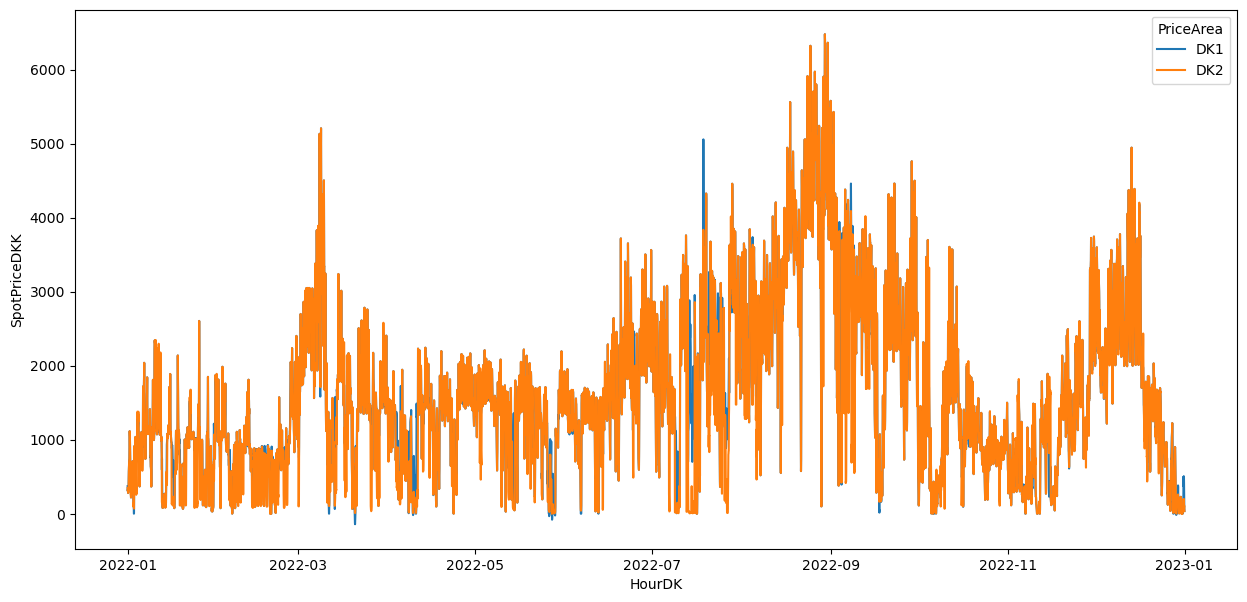

In [11]:
fig, ax = plt.subplots(figsize = (15, 7))

sns.lineplot(x = "HourDK", y = "SpotPriceDKK",
            hue = "PriceArea", data = data_dk_time_series)

plt.show()

The difference between DK1 and DK2 is not significant at all and it's hard to see if there are any seasonal effects (i.e. if the model is non-stationary)

We'll now try to predict the next value for DK1 and DK2 based on the previous observations, which can be done with the ARIMA (or any other extensions) model.

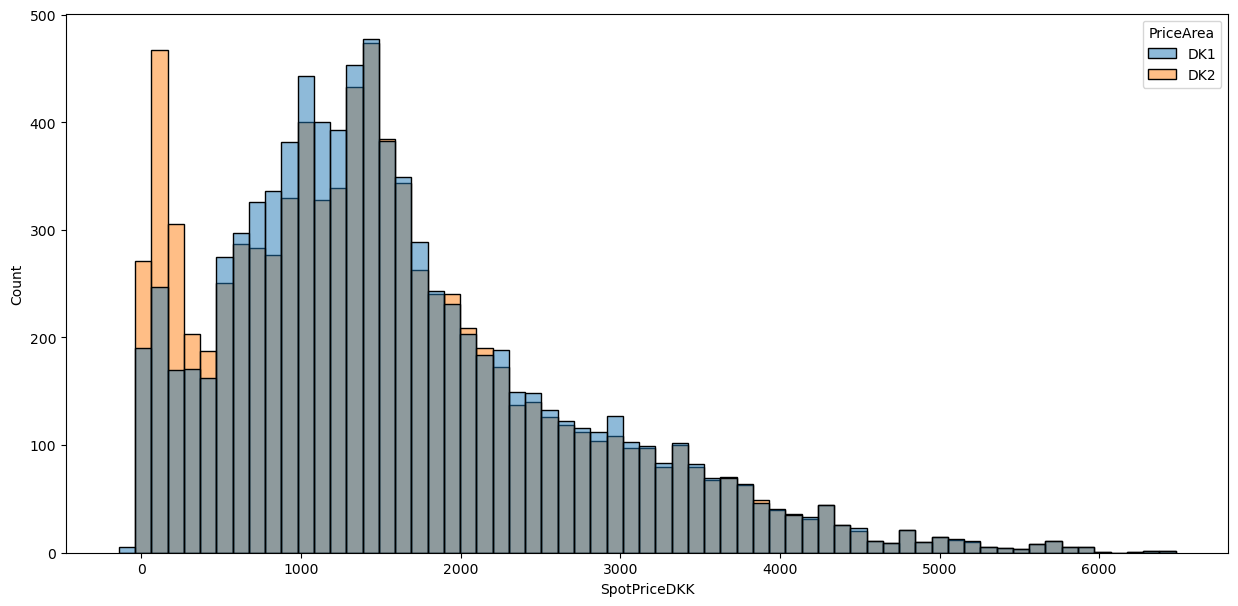

In [12]:
plt.subplots(figsize = (15, 7))

sns.histplot(data = data_dk_time_series, x = "SpotPriceDKK", hue = "PriceArea")

plt.show()

The histogram is distributed as a gaussian distribution with a heavy right tail.

Because of the similarity, Prices from DK1 will be used

In [13]:
data_dk_time_series_dk1 = data_dk_time_series[data_dk_time_series["PriceArea"].isin(["DK1"])]

data_dk_time_series_dk1.head(10)

,HourDK,SpotPriceDKK,PriceArea
1,2022-12-31 23:00:00,35.990002,DK1
11,2022-12-31 22:00:00,73.919998,DK1
14,2022-12-31 21:00:00,110.730003,DK1
25,2022-12-31 20:00:00,301.190002,DK1
28,2022-12-31 19:00:00,498.329987,DK1
39,2022-12-31 18:00:00,506.440002,DK1
42,2022-12-31 17:00:00,499.820007,DK1
53,2022-12-31 16:00:00,371.390015,DK1
56,2022-12-31 15:00:00,499.079987,DK1
67,2022-12-31 14:00:00,126.349998,DK1


lastly, we'll check if there is difference in variance and mean for 2 different parts of the time series (a dirty way to investigate if the time series is stationary or non-stationary)

In [20]:
price_list = data_dk_time_series_dk1["SpotPriceDKK"]

split = int(len(price_list) / 2)
price_list1, price_list2 = price_list[0:split], price_list[split:]
mean1, mean2 = price_list1.mean(), price_list2.mean()
std1, std2 = price_list1.std(), price_list2.std()
print('mean1=%.2f, mean2=%.2f' % (mean1, mean2))
print('std1=%.2f, std2=%.2f' % (std1, std2))

mean1=1986.63, mean2=1272.24
std1=1275.74, std2=677.04


Seems like there is some sort of seasonality / time dependency (thus non-stationary)

# PACF & ACF

In [14]:
data_dk_time_series_dk1 = data_dk_time_series_dk1.drop('PriceArea', axis=1)

data_dk_time_series_dk1.head(10)

,HourDK,SpotPriceDKK
1,2022-12-31 23:00:00,35.990002
11,2022-12-31 22:00:00,73.919998
14,2022-12-31 21:00:00,110.730003
25,2022-12-31 20:00:00,301.190002
28,2022-12-31 19:00:00,498.329987
39,2022-12-31 18:00:00,506.440002
42,2022-12-31 17:00:00,499.820007
53,2022-12-31 16:00:00,371.390015
56,2022-12-31 15:00:00,499.079987
67,2022-12-31 14:00:00,126.349998


In [56]:
data_dk1 = data_dk_time_series_dk1["SpotPriceDKK"]

data_dk1.index = data_dk_time_series_dk1["HourDK"]

data_dk1 = data_dk1.sort_index(ascending=True)

data_dk1.head(10)

HourDK
2022-01-01 00:00:00    372.200012
2022-01-01 01:00:00    307.350006
2022-01-01 02:00:00    321.410004
2022-01-01 03:00:00    338.059998
2022-01-01 04:00:00    280.130005
2022-01-01 05:00:00    295.230011
2022-01-01 06:00:00    301.850006
2022-01-01 07:00:00    321.700012
2022-01-01 08:00:00    369.299988
2022-01-01 09:00:00    520.929993
Name: SpotPriceDKK, dtype: float64

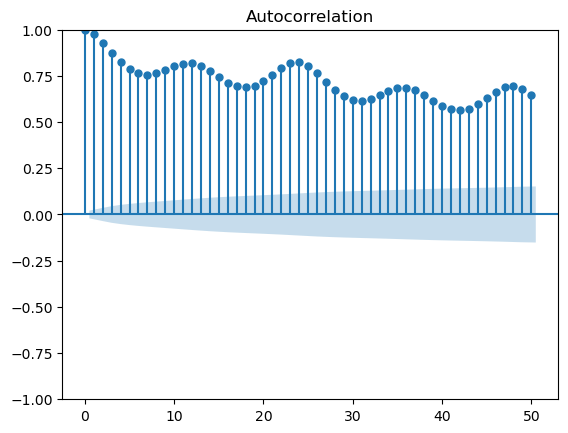

In [57]:
plot_acf(data_dk1,lags = 50)
plt.show()

c:\Users\emirh\anaconda3\envs\ML\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


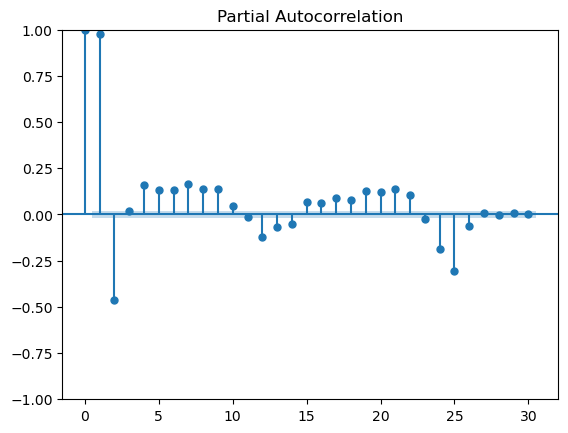

In [58]:
plot_pacf(data_dk1, lags = 30)
plt.show()

Based on the results from above, we should start with an Autoregressive model with correlated lags (1,2,3)

# Augmented Dickey-Fuller test

We'll now perform an Augmented Dickey-Fuller test to investigate if the time series is stationary by using statistics

In [60]:
result = adfuller(data_dk1)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -6.313270
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


Because of our p-value being below 0.05 the time series doesn't have a unit root and thus is stationary.

# ARIMA MODEL

Based on the PACF, we can determine the AR-term to be 3 and based on ACF the MA-term is 2 (hard to say, so we'll go with the simpler model)

In [180]:
clean_data_dk1 = data_dk1[~data_dk1.index.duplicated(keep = "first")]

clean_data_dk1.head(10)

HourDK
2022-01-01 00:00:00    372.200012
2022-01-01 01:00:00    307.350006
2022-01-01 02:00:00    321.410004
2022-01-01 03:00:00    338.059998
2022-01-01 04:00:00    280.130005
2022-01-01 05:00:00    295.230011
2022-01-01 06:00:00    301.850006
2022-01-01 07:00:00    321.700012
2022-01-01 08:00:00    369.299988
2022-01-01 09:00:00    520.929993
Name: SpotPriceDKK, dtype: float64

In [194]:
res = sm.tsa.arma_order_select_ic(clean_data_dk1, ic=['aic', 'bic'], trend='n')
print(res.aic_min_order)


c:\Users\emirh\anaconda3\envs\ML\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\emirh\anaconda3\envs\ML\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


(3, 2)


c:\Users\emirh\anaconda3\envs\ML\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [195]:
ARIMA_model = ARIMA(clean_data_dk1[len(clean_data_dk1)-100:], order = (3,0,2))

model_fit = ARIMA_model.fit()

print(model_fit.summary())

c:\Users\emirh\anaconda3\envs\ML\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\emirh\anaconda3\envs\ML\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
c:\Users\emirh\anaconda3\envs\ML\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:           SpotPriceDKK   No. Observations:                  100
Model:                 ARIMA(3, 0, 2)   Log Likelihood                -577.328
Date:                Sat, 27 May 2023   AIC                           1168.655
Time:                        14:19:03   BIC                           1186.892
Sample:                    12-27-2022   HQIC                          1176.036
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        257.2245    117.062      2.197      0.028      27.788     486.661
ar.L1          2.1337      0.249      8.555      0.000       1.645       2.623
ar.L2         -1.6485      0.469     -3.514      0.0

c:\Users\emirh\anaconda3\envs\ML\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [196]:
predictions = model_fit.forecast(100)

predictions.index = data_dk1.index[len(data_dk1.index)-100:]

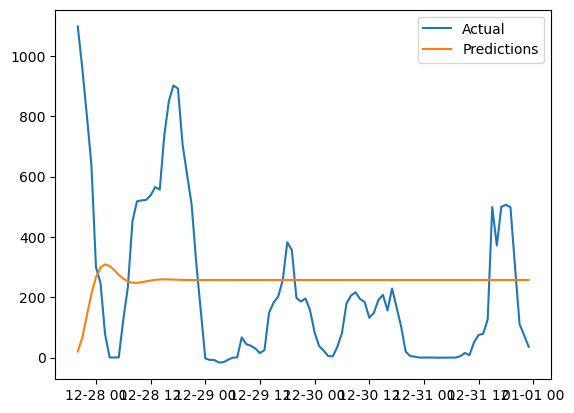

In [210]:
plt.plot(data_dk1[len(data_dk1)-100:], label='Actual')
plt.plot(predictions, label='Predictions')
plt.legend()
plt.show()

In [215]:
model_auto = pm.auto_arima(clean_data_dk1, start_p=1, start_q=1,
                    test='adf',       # use adftest to find optimal 'd'
                    max_p=6, max_q=6, # maximum p and q
                    m=1,              # frequency of series
                    d=None,           # let model determine 'd'
                    seasonal=False,   # No Seasonality
                    start_P=0, 
                    D=0, 
                    trace=True,
                    error_action='ignore',  
                    suppress_warnings=True, 
                    stepwise=True)

print(model_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=119163.715, Time=0.86 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=157621.396, Time=0.10 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=146372.493, Time=1.05 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=118810.535, Time=0.57 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=118818.401, Time=0.24 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=118819.392, Time=1.64 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=118699.349, Time=1.74 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=118716.713, Time=1.80 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=117699.842, Time=4.09 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=117739.949, Time=8.37 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=118696.065, Time=6.10 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=118682.871, Time=6.17 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=117743.584, Time=4.94 sec
 ARIMA(4,0,3

In [217]:
predictions_auto = model_auto.predict(n_periods = 50)

predictions_auto.index = data_dk1.index[len(data_dk1.index)-50:]

c:\Users\emirh\anaconda3\envs\ML\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


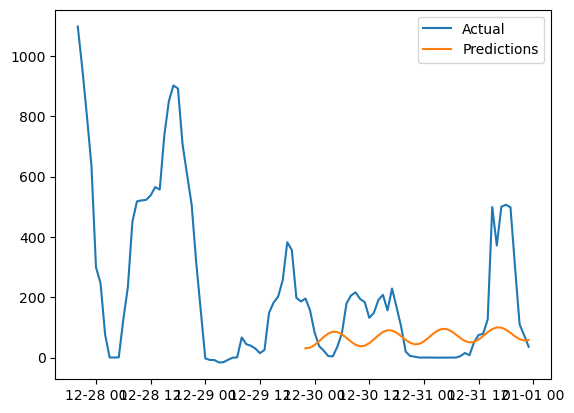

In [218]:
plt.plot(data_dk1[len(data_dk1)-100:], label='Actual')
plt.plot(predictions_auto, label='Predictions')
plt.legend()
plt.show()